In [245]:
import numpy as np 
import pandas as pd 

In [246]:
import keras
from keras import layers
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras_cv
from keras.layers import Conv2D, Dense, Flatten, Input ,MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score ,roc_curve ,auc


In [248]:
AD_path = 'Q1 Dataset/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
MCI_path = 'Q1 Dataset/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

In [249]:
ADS_paths = []
MCIS_paths = []

for imgname in os.listdir(AD_path):
    ADS_paths.append(os.path.join(AD_path,imgname))

for imgname in os.listdir(MCI_path):
    MCIS_paths.append(os.path.join(MCI_path,imgname))

In [250]:
print(len(ADS_paths) , len(MCIS_paths))

965 689


In [251]:
ADS_paths[0]

'Q1 Dataset/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD\\ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153020345_13_S200932_I390347.jpg'

In [252]:
SIZE_X = 64
SIZE_Y = 64 

In [253]:
def preprocess_image(image_path, target_size=(SIZE_X,SIZE_Y)):
    image = cv2.imread(image_path,0)
    #print(np.unique(image),image.shape)
    resized_image = cv2.resize(image, target_size)


    normalized_image = resized_image.astype(np.float32) / 255.0

    return normalized_image

In [254]:
preprocess_image(ADS_paths[0])

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [255]:
preprocessed_ADS = []
preprocessed_MCIS = []
for AD in ADS_paths:
    preprocessed_ADS.append(preprocess_image(AD).reshape(SIZE_X,SIZE_Y,1))
for mci in MCIS_paths:
    preprocessed_MCIS.append(preprocess_image(mci).reshape(SIZE_X,SIZE_Y,1))
preprocessed_ADS = np.array(preprocessed_ADS)
preprocessed_MCIS = np.array(preprocessed_MCIS)


Text(0.5, 1.0, 'Distribution of dataset')

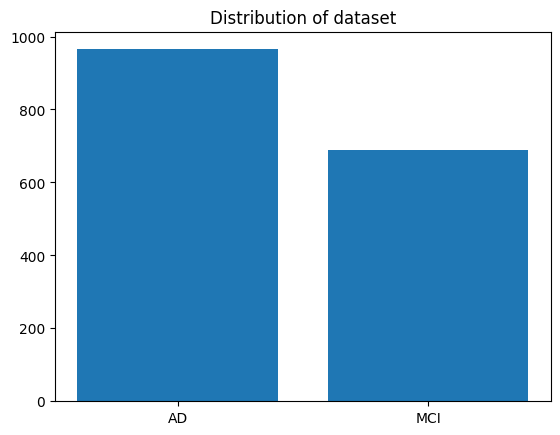

In [256]:
data_distribution = {'AD': len(preprocessed_ADS) , 'MCI' : len(preprocessed_MCIS)}
plt.bar(data_distribution.keys() , data_distribution.values())
plt.title('Distribution of dataset')

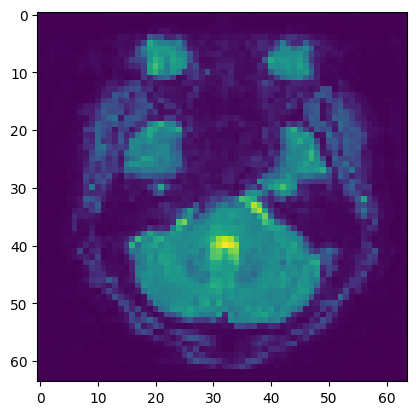

In [257]:
plt.imshow(preprocessed_ADS[0])

In [261]:
flip = keras.layers.RandomFlip(mode="horizontal")
augmented_AD1= flip(preprocessed_ADS)
augmented_MCI1= flip(preprocessed_MCIS)

In [262]:
rotation =keras.layers.RandomRotation(
    factor =math.pi /4 ,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
    value_range=(0, 1),
)
augmented_AD2= rotation(preprocessed_ADS)
augmented_MCI2= rotation(preprocessed_MCIS)

In [263]:
zoom = keras.layers.RandomZoom(
    height_factor = 0.2,
    width_factor= 0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    fill_value=0.0,
)
augmented_AD3= zoom(preprocessed_ADS)
augmented_MCI3= zoom(preprocessed_MCIS)

In [264]:
# plt.imshow(augmented_image3[0])

In [265]:
shift = keras.layers.RandomTranslation(
    height_factor = 0.1,
    width_factor = 0.1,
    fill_mode="reflect",
    interpolation="bilinear",
    fill_value=0.0,
)
augmented_AD4= shift(preprocessed_ADS)
augmented_MCI4= shift(preprocessed_MCIS)

In [266]:
# plt.imshow(augmented_image4[0])

In [267]:
shear =keras_cv.layers.RandomShear(
    x_factor= 0.2,
    y_factor= 0.2 ,
    interpolation="bilinear",
    fill_mode="reflect",
    fill_value=0.0,
)
augmented_AD5= shear(preprocessed_ADS)
augmented_MCI5= shear(preprocessed_MCIS)

In [268]:
# plt.imshow(augmented_image5[0])

In [269]:
len(preprocessed_ADS)

965

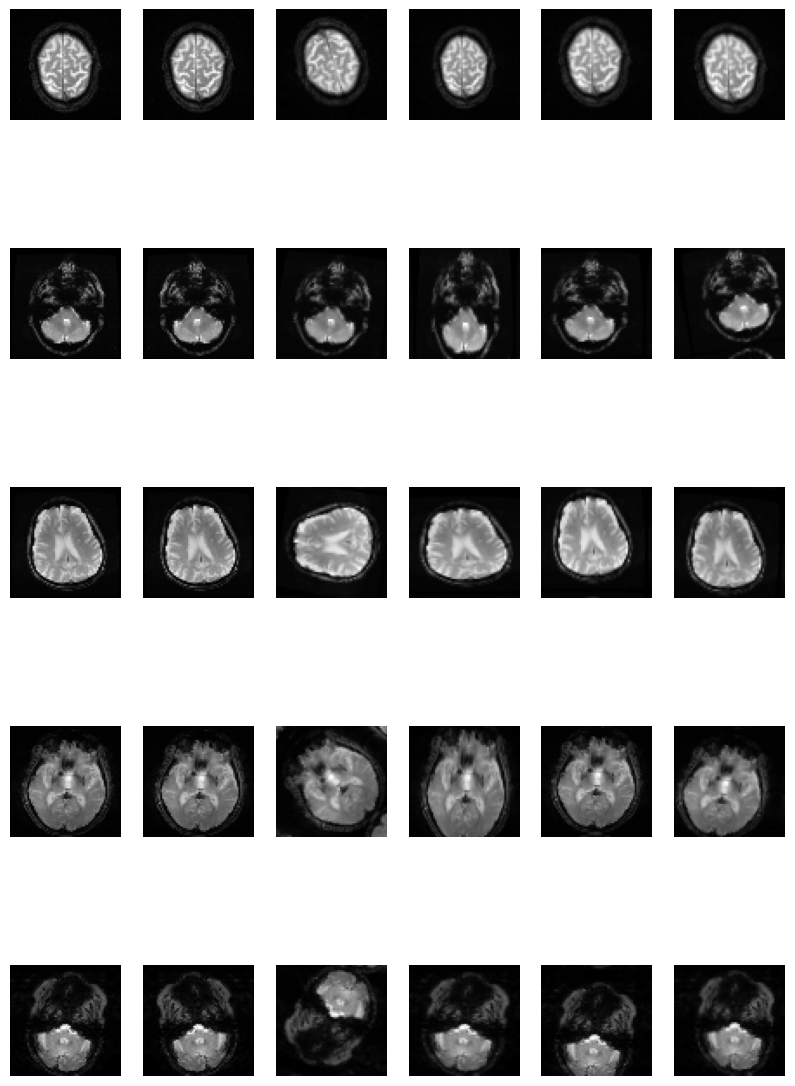

In [270]:
figure = plt.figure(figsize=(10,15))
for i in range(5):
    r = np.random.randint(len(preprocessed_ADS))
    figure.add_subplot(5, 6, 6*i+1)
    plt.axis('off')
    plt.imshow(preprocessed_ADS[r], cmap='gray')
    figure.add_subplot(5, 6, 6*i+2)
    plt.axis('off')
    plt.imshow(augmented_AD1[r], cmap='gray')
    figure.add_subplot(5, 6, 6*i+3)
    plt.axis('off')
    plt.imshow(augmented_AD2[r], cmap='gray')
    figure.add_subplot(5, 6, 6*i+4)
    plt.axis('off')
    plt.imshow(augmented_AD3[r], cmap='gray')
    figure.add_subplot(5, 6, 6*i+5)
    plt.axis('off')
    plt.imshow(augmented_AD4[r], cmap='gray')
    figure.add_subplot(5, 6, 6*i+6)
    plt.axis('off')
    plt.imshow(augmented_AD5[r], cmap='gray')




In [271]:
AD_data = np.concatenate((preprocessed_ADS, augmented_AD1, augmented_AD2, augmented_AD3, augmented_AD4, augmented_AD5))
y_AD = np.ones(AD_data.shape[0])


In [272]:
MCI_data = np.concatenate((preprocessed_MCIS, augmented_MCI1, augmented_MCI2, augmented_MCI3, augmented_MCI4, augmented_MCI5))
y_MCI = np.zeros(MCI_data.shape[0])

Text(0.5, 1.0, 'Distribution of the dataset after data augmentation')

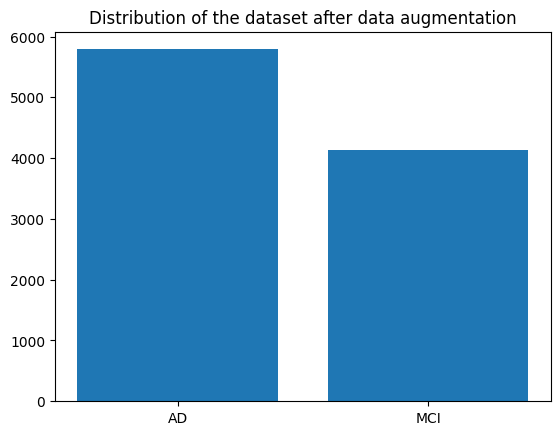

In [273]:
data_distribution = {'AD': len(AD_data) , 'MCI' : len(MCI_data)}
plt.bar(data_distribution.keys() , data_distribution.values())
plt.title('Distribution of the dataset after data augmentation')


In [274]:
AD_train_3, AD_test_3, yAD_train_3, yAD_test_3 = train_test_split(AD_data, y_AD, test_size=0.3, random_state=42)
MCI_train_3, MCI_test_3, yMCI_train_3, yMCI_test_3 = train_test_split(MCI_data, y_MCI, test_size=0.3, random_state=42)
AD_train_3, AD_val_3, yAD_train_3, yAD_val_3 = train_test_split(AD_train_3, yAD_train_3, test_size=0.1, random_state=42)
MCI_train_3, MCI_val_3, yMCI_train_3, yMCI_val_3 = train_test_split(MCI_train_3, yMCI_train_3, test_size=0.1, random_state=42)
X_train_3 = np.concatenate((AD_train_3,MCI_train_3))
X_test_3 = np.concatenate((AD_test_3,MCI_test_3))
X_val_3 = np.concatenate((AD_val_3,MCI_val_3))
y_train_3 = np.concatenate((yAD_train_3,yMCI_train_3))
y_test_3 = np.concatenate((yAD_test_3,yMCI_test_3))
y_val_3 = np.concatenate((yAD_val_3,yMCI_val_3))
permu = [i for  i in range(len(X_train_3))]
X_train_3 =X_train_3[permu].copy()
y_train_3 =y_train_3[permu].copy()


Text(0.5, 1.0, 'Distribution of the training dataset with a 0.7 split')

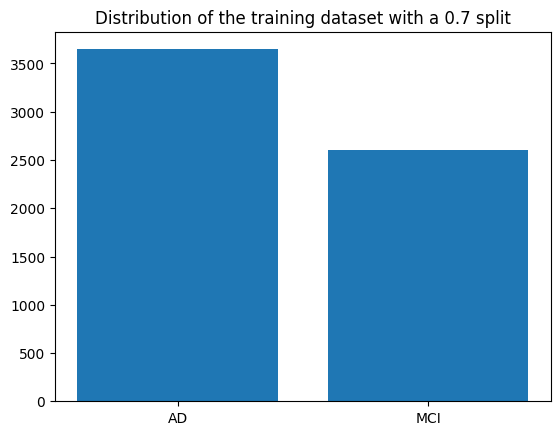

In [275]:
data_distribution = {'AD': sum(y_train_3==1) , 'MCI' : sum(y_train_3==0) }
plt.bar(data_distribution.keys() , data_distribution.values())
plt.title('Distribution of the training dataset with a 0.7 split')

In [276]:
AD_train_5, AD_test_5, yAD_train_5, yAD_test_5 = train_test_split(AD_data, y_AD, test_size=0.5, random_state=42)
MCI_train_5, MCI_test_5, yMCI_train_5, yMCI_test_5 = train_test_split(MCI_data, y_MCI, test_size=0.5, random_state=42)
AD_train_5, AD_val_5, yAD_train_5, yAD_val_5 = train_test_split(AD_train_5, yAD_train_5, test_size=0.1, random_state=42)
MCI_train_5, MCI_val_5, yMCI_train_5, yMCI_val_5 = train_test_split(MCI_train_5, yMCI_train_5, test_size=0.1, random_state=42)
X_train_5 = np.concatenate((AD_train_5,MCI_train_5))
X_test_5 = np.concatenate((AD_test_5,MCI_test_5))
X_val_5 = np.concatenate((AD_val_5,MCI_val_5))
y_train_5 = np.concatenate((yAD_train_5,yMCI_train_5))
y_test_5 = np.concatenate((yAD_test_5,yMCI_test_5))
y_val_5 = np.concatenate((yAD_val_5,yMCI_val_5))
permu = [i for  i in range(len(X_train_5))]
X_train_5 =X_train_5[permu].copy()
y_train_5 =y_train_5[permu].copy()

Text(0.5, 1.0, 'Distribution of the training dataset with a 0.5 split')

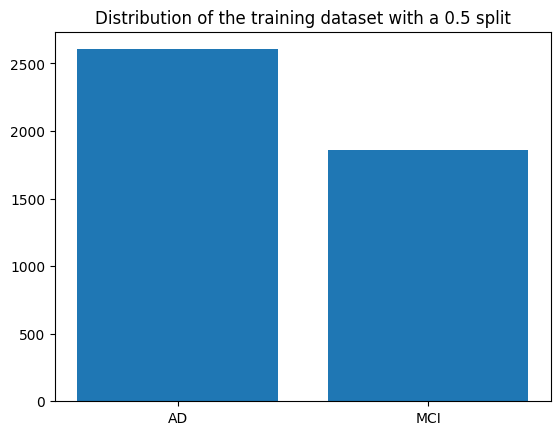

In [277]:
data_distribution = {'AD': sum(y_train_5==1) , 'MCI' : sum(y_train_5==0) }
plt.bar(data_distribution.keys() , data_distribution.values())
plt.title('Distribution of the training dataset with a 0.5 split')

In [278]:
Proposed_model = keras.Sequential()
Proposed_model.add(Input(shape=(64, 64, 1)))
Proposed_model.add(Conv2D(32, (3, 3)))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(Conv2D(32, (3, 3)))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(MaxPooling2D(pool_size=2))
Proposed_model.add(Conv2D(32, (3, 3)))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(Conv2D(32, (3, 3)))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(MaxPooling2D(pool_size=2))
Proposed_model.add(Flatten())
Proposed_model.add(Dense(128),keras.initializers.glorot_uniform(seed=42))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(Dense(64),keras.initializers.glorot_uniform(seed=42))
Proposed_model.add(keras.layers.BatchNormalization())
Proposed_model.add(keras.layers.Activation('relu'))
Proposed_model.add(Dense(2),keras.initializers.glorot_uniform(seed=42))
Proposed_model.add(keras.layers.Activation('softmax'))

In [279]:
Testin_model_1 = keras.Sequential()
Testin_model_1.add(Input(shape=(64, 64, 1)))
Testin_model_1.add(Conv2D(32, (3, 3)))
Testin_model_1.add(keras.layers.BatchNormalization())
Testin_model_1.add(keras.layers.Activation('relu'))
Testin_model_1.add(MaxPooling2D(pool_size=2))
Testin_model_1.add(Conv2D(32, (3, 3)))
Testin_model_1.add(keras.layers.BatchNormalization())
Testin_model_1.add(keras.layers.Activation('relu'))
Testin_model_1.add(MaxPooling2D(pool_size=2))
Testin_model_1.add(Flatten())
Testin_model_1.add(Dense(128),keras.initializers.glorot_uniform(seed=42))
Testin_model_1.add(keras.layers.BatchNormalization())
Testin_model_1.add(keras.layers.Activation('relu'))
Testin_model_1.add(Dense(2),keras.initializers.glorot_uniform(seed=42))
Testin_model_1.add(keras.layers.Activation('softmax'))

In [280]:
Testin_model_2 = keras.Sequential()
Testin_model_2.add(Input(shape=(64, 64, 1)))
Testin_model_2.add(Conv2D(32, (3, 3)))
Testin_model_2.add(keras.layers.BatchNormalization())
Testin_model_2.add(keras.layers.Activation('relu'))
Testin_model_2.add(Conv2D(32, (3, 3)))
Testin_model_2.add(keras.layers.BatchNormalization())
Testin_model_2.add(keras.layers.Activation('relu'))
Testin_model_2.add(MaxPooling2D(pool_size=2))
Testin_model_2.add(Flatten())
Testin_model_2.add(Dense(128),keras.initializers.glorot_uniform(seed=42))
Testin_model_2.add(keras.layers.BatchNormalization())
Testin_model_2.add(keras.layers.Activation('relu'))
Testin_model_2.add(Dense(64),keras.initializers.glorot_uniform(seed=42))
Testin_model_2.add(keras.layers.BatchNormalization())
Testin_model_2.add(keras.layers.Activation('relu'))
Testin_model_2.add(Dense(2),keras.initializers.glorot_uniform(seed=42))
Testin_model_2.add(keras.layers.Activation('softmax'))

In [9]:
import numpy as np
import torch
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split


np.random.seed(42)

X,y = make_gaussian_quantiles(n_samples=300 , n_features=8 , n_classes=2 , random_state=42)
X_train , X_test , Y_train , Y_test = train_test_split(X , y , test_size=0.2 , random_state=42)



LEARNING_RATE = 0.01
EPOCHS = 100
TRAIN_LEN = 240
TEST_LEN = 60





def relu(z):
    return np.maximum(0.0,z)

def relu_prim(z) -> int:
    return z>0

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_prim(z):
    return z * (1 - z)

def add_ones_col(arr : np.ndarray) -> np.ndarray:
    ones_col = np.ones((arr.shape[0] , 1))
    final = np.hstack((arr,ones_col))
    return final



class Layer :

    def __init__(self , n_features , n_neurons , activation_func) -> None:
        self.weights = np.random.randn(n_neurons , n_features+1)
        self.activation_func = activation_func
        

    def forward(self , X : np.ndarray) :
        print(self.weights.shape , X.T.shape)
        self.weighted_sum = np.dot(self.weights , X.T)
        self.output = self.activation_func(self.weighted_sum)


    def backward(self , X):
        pass





class NeuralNetwork : 

    def __init__(self , learning_rate = LEARNING_RATE , epochs = EPOCHS) -> None:
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hiddenlayer = Layer(8,1000,relu)
        self.outputlayer = Layer(1000,1,sigmoid)


    def loss(self , predictions : np.ndarray , targets : np.ndarray):
        return (np.square(np.subtract(targets , predictions)))/TRAIN_LEN
    

    def backpropagation(self , X : np.ndarray , targets : np.ndarray):
        z1 : np.ndarray
        z2 : np.ndarray
        a1 : np.ndarray
        a2 : np.ndarray
        w1 : np.ndarray
        w2 : np.ndarray

        z1 = self.hiddenlayer.weighted_sum
        a1 = self.hiddenlayer.output
        w1 = self.hiddenlayer.weights

        z2 = self.outputlayer.weighted_sum
        a2 = self.outputlayer.output
        w2 = self.outputlayer.weights

        print(f"X.T : {X.T.shape}")
        print(f"z1 : {z1.shape}")
        print(f"z2 : {z2.shape}")
        print(f"a1 : {a1.shape}")
        print(f"a2 : {a2.shape}")
        print(f"w1 : {w1.shape}")
        print(f"w2 : {w2.shape}")

        gradient1 = np.dot((-2/TRAIN_LEN)*np.multiply(np.multiply((targets - a2) , a2) , (1-a2)) , a1.T)
        print("NIMA:",np.dot((-2/TRAIN_LEN)*np.multiply(np.multiply((targets - a2) , a2) , (1-a2)).T , w2).T.shape,relu_prim(a1).shape)
        gradient2 = np.dot((np.multiply(np.dot((-2/TRAIN_LEN)*np.multiply(np.multiply((targets - a2) , a2) , (1-a2)).T , w2).T , relu_prim(a1))) , X)
        

        
        w1 -= self.learning_rate * gradient1
        w2 -= self.learning_rate * gradient2


    def predict(self , X):
        self.hiddenlayer.forward(X)
        self.outputlayer.forward(self.hiddenlayer.output)
        return self.outputlayer.output


    def train(self , training_data : np.ndarray , targets : np.ndarray):
        for epoch in range(self.epochs):
            training_data = add_ones_col(training_data)
            print(training_data)

            self.hiddenlayer.forward(training_data)
            print(add_ones_col(self.hiddenlayer.output.T).shape)
            self.outputlayer.forward(add_ones_col(self.hiddenlayer.output.T))

            loss = self.loss(self.outputlayer.output , targets)
            print(f"Epoch : {epoch} - loss : {loss}")

            self.backpropagation(training_data , targets)


    
    def test(self , test_data : np.ndarray , targets : np.ndarray):
        predictions = self.predict(test_data)
        predictions = predictions > 0.5
        accuracy = np.mean(predictions == targets.reshape(-1, 1))
        print(f'Test Accuracy: {accuracy}')
        return accuracy

    

nn = NeuralNetwork()
nn.train(X_train , Y_train)


[[ 0.10589445  0.58441298  1.97644058 ... -0.89878405 -1.33031363
   1.        ]
 [-0.65407568 -1.8306329   0.5112026  ...  1.61227826  1.31491445
   1.        ]
 [ 1.47654035  1.38009135 -0.6255627  ... -0.55030515 -0.67162337
   1.        ]
 ...
 [ 0.28328787 -0.25890497  0.5866938  ...  0.12637958  1.938929
   1.        ]
 [-0.1601328   0.67134008  0.21319663 ...  1.07600714  0.02131165
   1.        ]
 [ 1.12411272  0.94752646 -0.77287767 ... -0.62671722  0.86239347
   1.        ]]
(1000, 9) (9, 240)
(240, 1001)
(1, 1001) (1001, 240)
Epoch : 0 - loss : [[0.00000000e+00 1.92511555e-20 4.81006831e-20 4.16666667e-03
  4.16666660e-03 4.16666663e-03 4.15682074e-03 3.34248594e-17
  4.16666667e-03 4.16666667e-03 4.89678709e-50 4.16388215e-03
  4.16666667e-03 4.15868273e-03 2.02655924e-56 1.68648121e-03
  4.16666667e-03 2.44358198e-14 3.23042073e-22 0.00000000e+00
  0.00000000e+00 4.16621505e-03 2.32625222e-18 9.27426212e-20
  0.00000000e+00 4.16666576e-03 4.40289480e-11 4.16666667e-03
  7.

ValueError: operands could not be broadcast together with shapes (1001,240) (1000,240) 

In [281]:
Proposed_model_with_dropout = keras.Sequential()
Proposed_model_with_dropout.add(Input(shape=(64, 64, 1)))
Proposed_model_with_dropout.add(Conv2D(32, (3, 3)))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(keras.layers.Dropout(0.2))
Proposed_model_with_dropout.add(Conv2D(32, (3, 3)))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(MaxPooling2D(pool_size=2))
Proposed_model_with_dropout.add(Conv2D(32, (3, 3)))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(keras.layers.Dropout(0.2))
Proposed_model_with_dropout.add(Conv2D(32, (3, 3)))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(MaxPooling2D(pool_size=2))
Proposed_model_with_dropout.add(Flatten())
Proposed_model_with_dropout.add(Dense(128),keras.initializers.glorot_uniform(seed=42))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(Dense(64),keras.initializers.glorot_uniform(seed=42))
Proposed_model_with_dropout.add(keras.layers.BatchNormalization())
Proposed_model_with_dropout.add(keras.layers.Activation('relu'))
Proposed_model_with_dropout.add(keras.layers.Dropout(0.2))
Proposed_model_with_dropout.add(Dense(2),keras.initializers.glorot_uniform(seed=42))
Proposed_model_with_dropout.add(keras.layers.Activation('softmax'))

In [282]:
Proposed_model_without_glorot = keras.Sequential()
Proposed_model_without_glorot.add(Input(shape=(64, 64, 1)))
Proposed_model_without_glorot.add(Conv2D(32, (3, 3)))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(Conv2D(32, (3, 3)))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(MaxPooling2D(pool_size=2))
Proposed_model_without_glorot.add(Conv2D(32, (3, 3)))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(Conv2D(32, (3, 3)))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(MaxPooling2D(pool_size=2))
Proposed_model_without_glorot.add(Flatten())
Proposed_model_without_glorot.add(Dense(128),keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(Dense(64),keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
Proposed_model_without_glorot.add(keras.layers.BatchNormalization())
Proposed_model_without_glorot.add(keras.layers.Activation('relu'))
Proposed_model_without_glorot.add(Dense(2),keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
Proposed_model_without_glorot.add(keras.layers.Activation('softmax'))

In [283]:
Proposed_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [284]:
Testin_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=6e-5),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [285]:
Testin_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=6e-5),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [286]:
Proposed_model_with_dropout.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [287]:
Proposed_model_without_glorot.compile(optimizer=keras.optimizers.Adam(learning_rate=6e-5), 
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [288]:
# y = to_categorical(y_train,num_classes=2)

In [289]:
# np.unique(y_train)

In [290]:
Proposed_model.save("model.keras")
history1 = Proposed_model.fit(X_train_3,to_categorical(y_train_3,num_classes=2),epochs=20,batch_size=64 ,  validation_data=(X_val_3,to_categorical(y_val_3,num_classes=2)))



Epoch 1/20


98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.6133 - loss: 0.7062 - val_accuracy: 0.4957 - val_loss: 0.6921
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.8092 - loss: 0.4163 - val_accuracy: 0.4253 - val_loss: 0.7183
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.8785 - loss: 0.3019 - val_accuracy: 0.4167 - val_loss: 1.2524
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9235 - loss: 0.2042 - val_accuracy: 0.4856 - val_loss: 1.1837
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9664 - loss: 0.1101 - val_accuracy: 0.5417 - val_loss: 1.8422
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9848 - loss: 0.0644 - val_accuracy: 0.5862 - val_loss: 2.4747
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9840 - loss: 0.0563 - val_accuracy: 0.6379 - val_loss: 1.6035
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9931 - loss: 0.0284 - val_accuracy: 0.714

In [291]:
y_pred = np.argmax(Proposed_model.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Confusion Matrix:
[[ 757  484]
 [  82 1655]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.90      0.61      0.73      1241
         MCI       0.77      0.95      0.85      1737

    accuracy                           0.81      2978
   macro avg       0.84      0.78      0.79      2978
weighted avg       0.83      0.81      0.80      2978

AUC:
0.7813920561955116


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


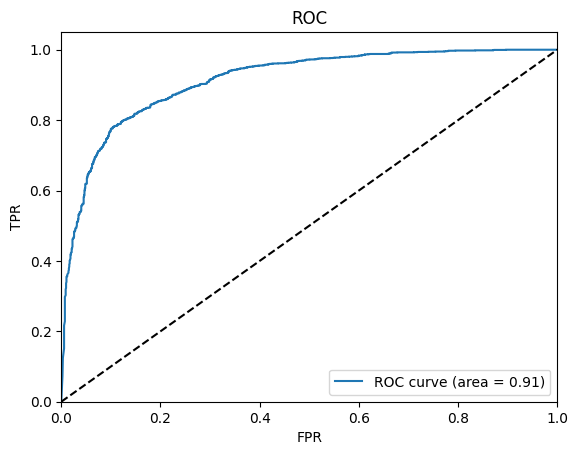

In [292]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Proposed_model.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [293]:
Proposed_model = keras.saving.load_model("model.keras")
history2 = Proposed_model.fit(X_train_5,to_categorical(y_train_5,num_classes=2),epochs=20,batch_size=64, validation_data=(X_val_5,to_categorical(y_val_5,num_classes=2)))


Epoch 1/20


c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 54 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.5972 - loss: 0.7344 - val_accuracy: 0.5835 - val_loss: 0.6850
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.7904 - loss: 0.4540 - val_accuracy: 0.4165 - val_loss: 0.8440
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.8807 - loss: 0.3021 - val_accuracy: 0.4165 - val_loss: 0.9900
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.9274 - loss: 0.2186 - val_accuracy: 0.4165 - val_loss: 0.8652
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.9661 - loss: 0.1167 - val_accuracy: 0.5594 - val_loss: 1.1068
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9837 - loss: 0.0685 - val_accuracy: 0.5755 - val_loss: 1.6618
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.9904 - loss: 0.0458 - val_accuracy: 0.5795 - val_loss: 2.5597
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.9975 - loss: 0.0208 - val_accuracy: 0.589

In [294]:
y_pred = np.argmax(Proposed_model.predict(X_test_5),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_5, y_pred))
print("Classification Report:")
print(classification_report(y_test_5, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_5, y_pred))

156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Confusion Matrix:
[[1615  452]
 [ 374 2521]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.81      0.78      0.80      2067
         MCI       0.85      0.87      0.86      2895

    accuracy                           0.83      4962
   macro avg       0.83      0.83      0.83      4962
weighted avg       0.83      0.83      0.83      4962

AUC:
0.8260686685166106


156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


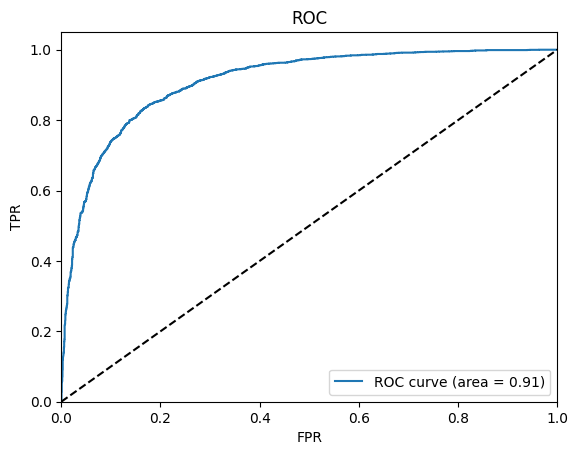

In [295]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Proposed_model.predict(X_test_5)
y_test_33 = to_categorical(y_test_5,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [296]:
history3 =Testin_model_1.fit(X_train_3,to_categorical(y_train_3,num_classes=2),epochs=20,batch_size=64, validation_data=(X_val_3,to_categorical(y_val_3,num_classes=2)))


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5791 - loss: 0.6972 - val_accuracy: 0.5833 - val_loss: 0.7558
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7633 - loss: 0.5004 - val_accuracy: 0.5833 - val_loss: 0.9645
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8184 - loss: 0.4297 - val_accuracy: 0.5833 - val_loss: 1.0803
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8509 - loss: 0.3802 - val_accuracy: 0.5833 - val_loss: 1.0528
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8856 - loss: 0.3235 - val_accuracy: 0.5848 - val_loss: 0.7709
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9112 - loss: 0.2885 - val_accuracy: 0.6207 - val_loss: 0.6594
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9383 - loss: 0.2438 - val_accuracy: 0.7241 - val_loss: 0.5278
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9506 - loss: 0.2152 - val_accur

In [297]:
history4 =Testin_model_2.fit(X_train_3,to_categorical(y_train_3,num_classes=2),epochs=20,batch_size=64, validation_data=(X_val_3,to_categorical(y_val_3,num_classes=2)))

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.6185 - loss: 0.6710 - val_accuracy: 0.5833 - val_loss: 0.7238
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.8235 - loss: 0.4090 - val_accuracy: 0.5833 - val_loss: 0.6941
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9097 - loss: 0.2827 - val_accuracy: 0.5833 - val_loss: 0.7339
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.9590 - loss: 0.1838 - val_accuracy: 0.5833 - val_loss: 0.9996
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.9869 - loss: 0.1164 - val_accuracy: 0.5848 - val_loss: 1.4240
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9965 - loss: 0.0738 - val_accuracy: 0.5963 - val_loss: 0.9958
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.9987 - loss: 0.0516 - val_accuracy: 0.7960 - val_loss: 0.4761
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 1.0000 - loss: 0.0372 - val_accu

In [298]:
history5 =Proposed_model_with_dropout.fit(X_train_3,to_categorical(y_train_3,num_classes=2),epochs=20,batch_size=64, validation_data=(X_val_3,to_categorical(y_val_3,num_classes=2)))

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - accuracy: 0.5805 - loss: 0.8271 - val_accuracy: 0.5833 - val_loss: 0.9501
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.7281 - loss: 0.5355 - val_accuracy: 0.4167 - val_loss: 0.7436
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.7733 - loss: 0.4711 - val_accuracy: 0.5460 - val_loss: 0.6950
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 34s 349ms/step - accuracy: 0.8199 - loss: 0.3870 - val_accuracy: 0.5532 - val_loss: 0.7017
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.8591 - loss: 0.3246 - val_accuracy: 0.4770 - val_loss: 0.8204
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - accuracy: 0.8901 - loss: 0.2761 - val_accuracy: 0.6293 - val_loss: 1.0388
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.9085 - loss: 0.2289 - val_accuracy: 0.6063 - val_loss: 1.1069
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.9326 - loss: 0.1825 - val_accu

In [299]:
history6 =Proposed_model_without_glorot.fit(X_train_3,to_categorical(y_train_3,num_classes=2),epochs=20,batch_size=64, validation_data=(X_val_3,to_categorical(y_val_3,num_classes=2)))

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 253ms/step - accuracy: 0.5828 - loss: 0.7157 - val_accuracy: 0.5833 - val_loss: 0.6830
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.7691 - loss: 0.4884 - val_accuracy: 0.5273 - val_loss: 0.6903
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.8480 - loss: 0.3853 - val_accuracy: 0.5417 - val_loss: 0.6963
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8940 - loss: 0.3091 - val_accuracy: 0.5819 - val_loss: 0.7044
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.9352 - loss: 0.2550 - val_accuracy: 0.5905 - val_loss: 0.8260
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.9584 - loss: 0.2035 - val_accuracy: 0.6580 - val_loss: 0.6241
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.9803 - loss: 0.1636 - val_accuracy: 0.7672 - val_loss: 0.5163
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.9875 - loss: 0.1337 - val_accu

In [300]:
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(train_loss) + 1)
    
    fig, axs = plt.subplots(2, figsize=(10, 7))
    fig.suptitle('Training and Validation Metrics')
    
    # Loss plot
    axs[0].plot(epochs, train_loss, label='Training loss', c='red')
    axs[0].plot(epochs, val_loss, label='Validation loss', c='blue')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_ylim([0, 1.5])
    
    # Accuracy plot
    axs[1].plot(epochs, train_acc, label='Training accuracy', c='red')
    axs[1].plot(epochs, val_acc, label='Validation accuracy', c='blue')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

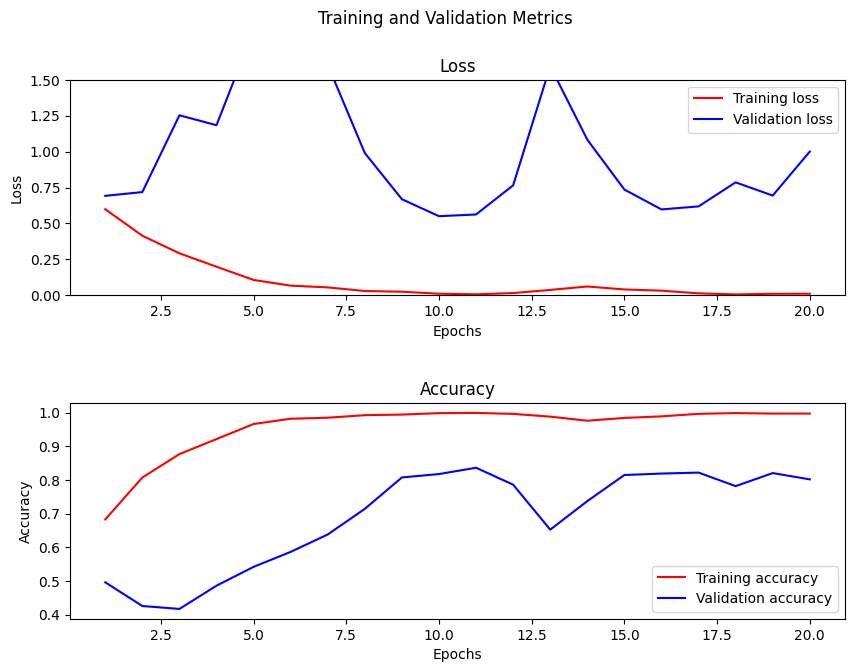

In [301]:
plot_loss_acc(history1)

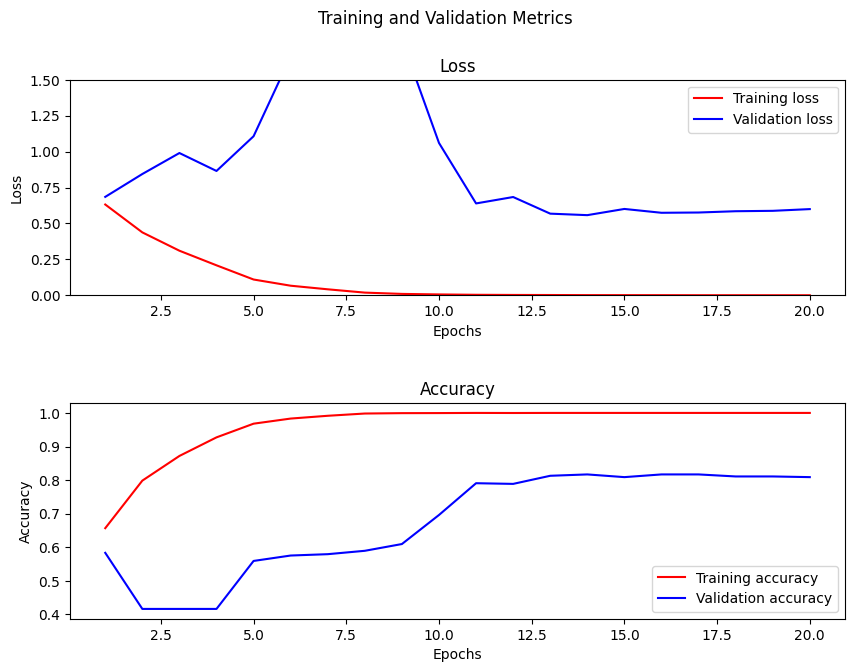

In [302]:
plot_loss_acc(history2)

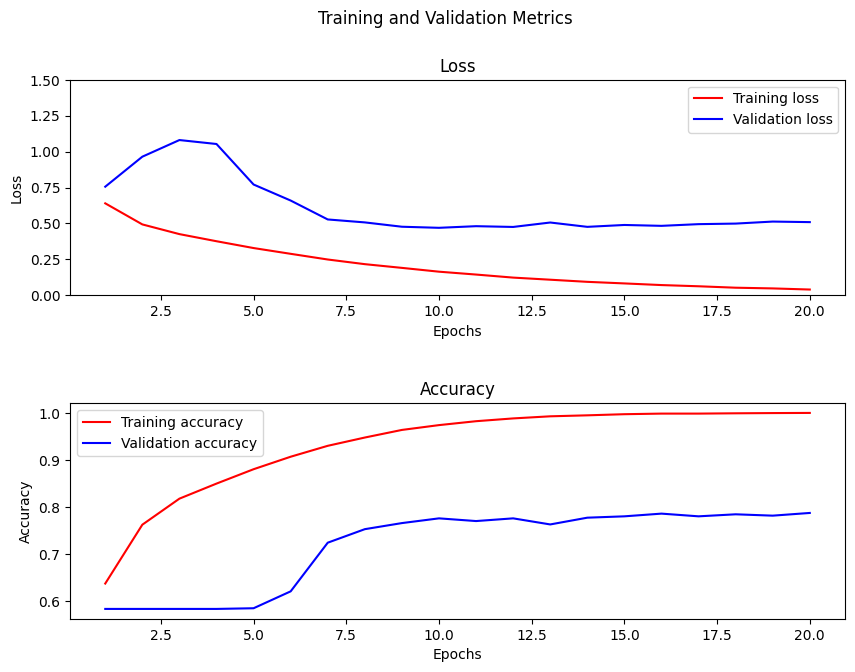

In [303]:
plot_loss_acc(history3)

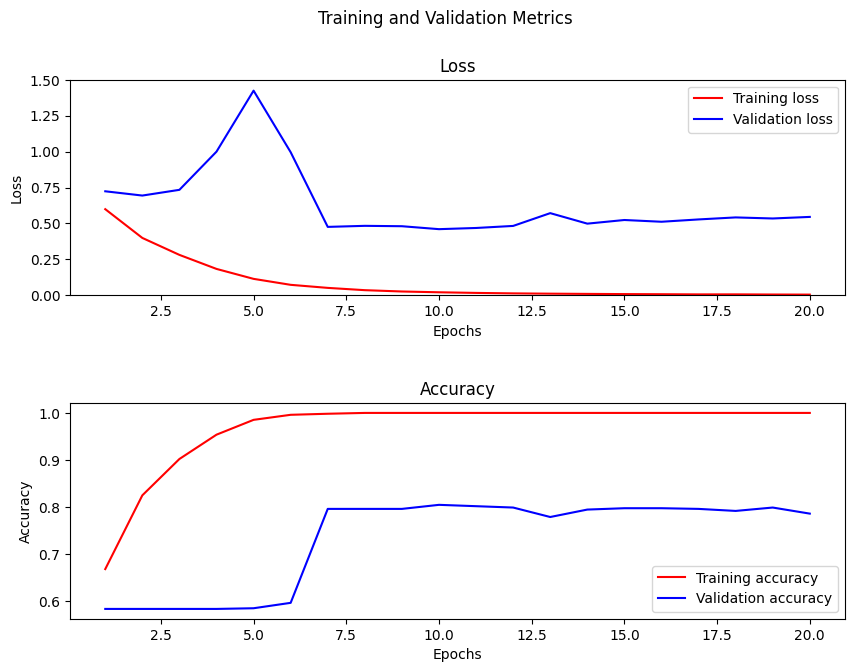

In [304]:
plot_loss_acc(history4)

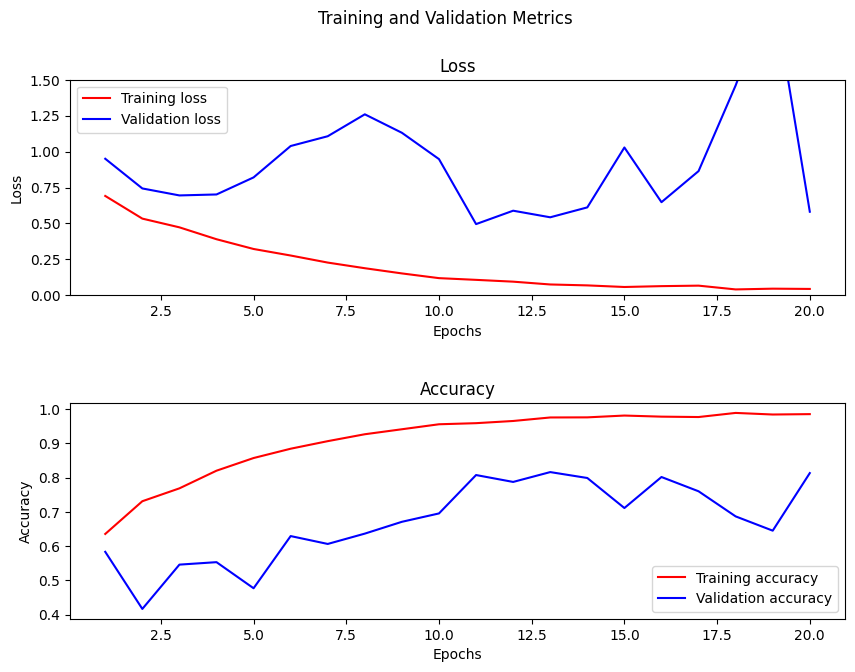

In [305]:
plot_loss_acc(history5)

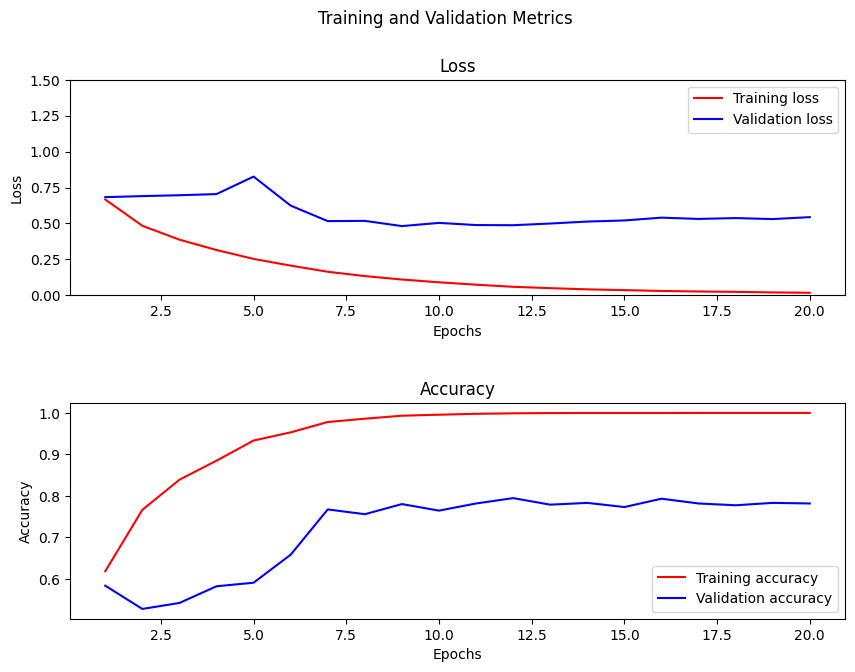

In [306]:
plot_loss_acc(history6)

In [307]:
y_pred = np.argmax(Proposed_model.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))




94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Confusion Matrix:
[[ 971  270]
 [ 234 1503]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.81      0.78      0.79      1241
         MCI       0.85      0.87      0.86      1737

    accuracy                           0.83      2978
   macro avg       0.83      0.82      0.83      2978
weighted avg       0.83      0.83      0.83      2978

AUC:
0.8238592477235056


In [308]:
y_pred = np.argmax(Testin_model_1.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Confusion Matrix:
[[ 975  266]
 [ 308 1429]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.76      0.79      0.77      1241
         MCI       0.84      0.82      0.83      1737

    accuracy                           0.81      2978
   macro avg       0.80      0.80      0.80      2978
weighted avg       0.81      0.81      0.81      2978

AUC:
0.8041697574290796


In [309]:
y_pred = np.argmax(Testin_model_2.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Confusion Matrix:
[[ 959  282]
 [ 256 1481]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.79      0.77      0.78      1241
         MCI       0.84      0.85      0.85      1737

    accuracy                           0.82      2978
   macro avg       0.81      0.81      0.81      2978
weighted avg       0.82      0.82      0.82      2978

AUC:
0.8126916794588278


In [310]:
y_pred = np.argmax(Proposed_model_with_dropout.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Confusion Matrix:
[[1037  204]
 [ 307 1430]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.77      0.84      0.80      1241
         MCI       0.88      0.82      0.85      1737

    accuracy                           0.83      2978
   macro avg       0.82      0.83      0.83      2978
weighted avg       0.83      0.83      0.83      2978

AUC:
0.8294374650042193


In [311]:

y_pred = np.argmax(Proposed_model_without_glorot.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Confusion Matrix:
[[ 916  325]
 [ 238 1499]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.79      0.74      0.76      1241
         MCI       0.82      0.86      0.84      1737

    accuracy                           0.81      2978
   macro avg       0.81      0.80      0.80      2978
weighted avg       0.81      0.81      0.81      2978

AUC:
0.8005482884946631


In [312]:
y_pred = np.argmax(Testin_model_1.predict(X_test_3),axis= 1)
print("Confusion Matrix:")
print(confusion_matrix(y_test_3, y_pred))
print("Classification Report:")
print(classification_report(y_test_3, y_pred, target_names=['AD', 'MCI']))
print("AUC:")
print(roc_auc_score(y_test_3, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Confusion Matrix:
[[ 975  266]
 [ 308 1429]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.76      0.79      0.77      1241
         MCI       0.84      0.82      0.83      1737

    accuracy                           0.81      2978
   macro avg       0.80      0.80      0.80      2978
weighted avg       0.81      0.81      0.81      2978

AUC:
0.8041697574290796


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


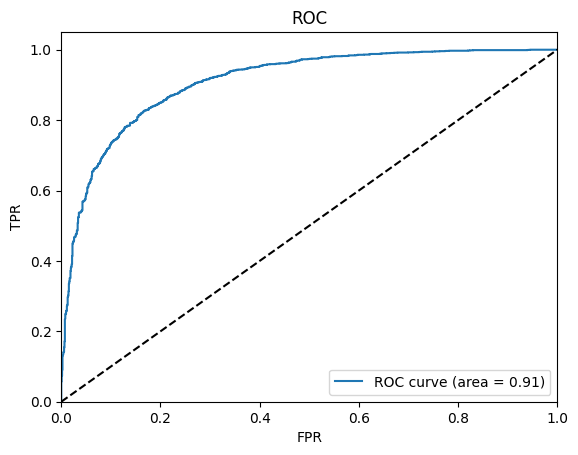

In [313]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Proposed_model.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


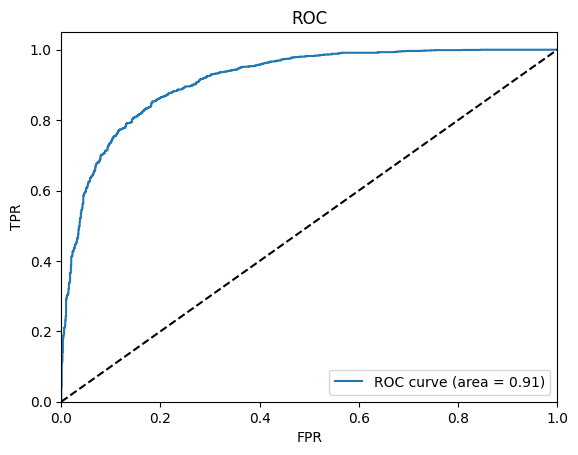

In [314]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Proposed_model_with_dropout.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


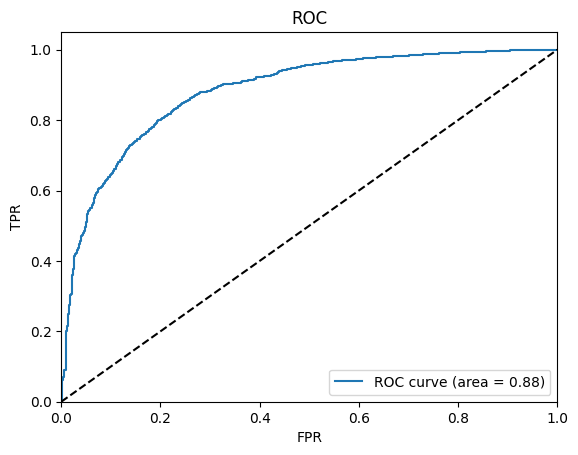

In [315]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Proposed_model_without_glorot.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


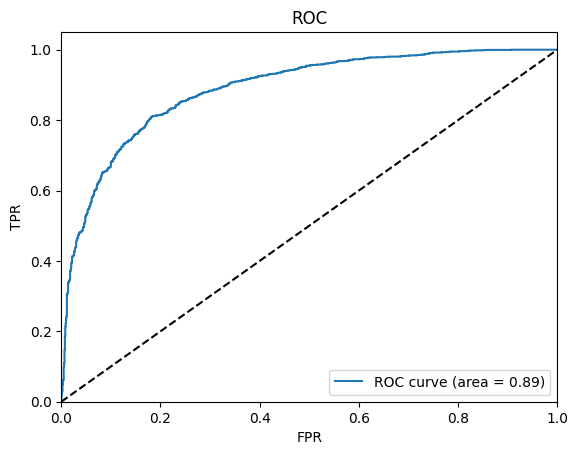

In [316]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Testin_model_1.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


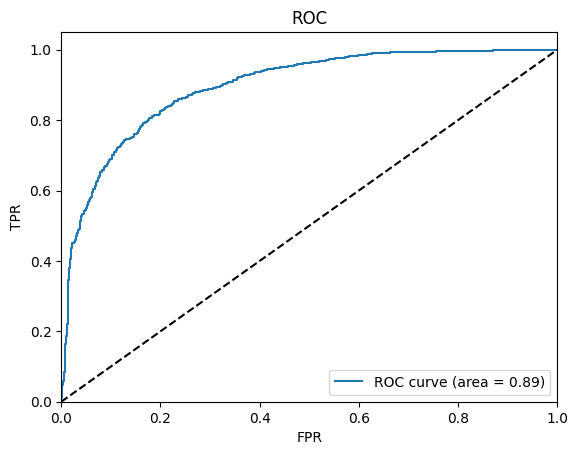

In [317]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred =  Testin_model_2.predict(X_test_3)
y_test_33 = to_categorical(y_test_3,num_classes=2)
for i in range(2):  
    fpr[i], tpr[i], _ = roc_curve(y_test_33[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()